In [18]:
import random
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from multiprocessing import Pool
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

n = 10
# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
seed = 128
RNG = torch.Generator().manual_seed(seed)#42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

Running on device: CUDA


In [19]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., device='cuda'):
        self.std = std
        self.mean = mean
        self.device = device
        
    def __call__(self, tensor):
        _max = tensor.max()
        _min = tensor.min()
        tensor = tensor + torch.randn(tensor.size()).to(self.device) * self.std + self.mean
        tensor = torch.clamp(tensor, min=_min, max=_max)
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [20]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []
    all_inputs = []
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for idx, l in enumerate(losses):
            all_losses.append(l)
            all_inputs.append(inputs[idx].cpu().numpy())
    return all_inputs, np.array(all_losses)

In [21]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    attack_model.fit(sample_loss, members)
    score = attack_model.score(sample_loss, members)
    preds = attack_model.predict(sample_loss)
    correct_idx= np.where(preds == members)[0]
    wrong_idx = np.where(preds != members)[0]
    return score, correct_idx, wrong_idx

In [22]:
def make_boxplot(data, title, x_label, y_label, x_ticklabels=None, save_path=None, showfliers=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.boxplot(data=data, ax=ax, showfliers=showfliers)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if x_ticklabels is not None:
        ax.set_xticklabels(x_ticklabels)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [23]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# for the unlearning algorithm we'll also need a split of the train set into
# forget_set and a retain_set
forget_set, retain_set = torch.utils.data.random_split(train_set, [0.1, 0.9], generator=RNG)
forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=64, shuffle=False, num_workers=2, generator=RNG
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=2, generator=RNG
)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*8*64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [25]:
def test(model):
    criterion = nn.CrossEntropyLoss()
    test_acc = 0
    for x,y in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        loss = criterion(pred, y)
        acc = (pred.argmax(dim=1) == y).float().mean()
        test_acc += acc.item()
    tqdm.write(f"Test accuracy: {test_acc / len(test_loader)}")

In [29]:
def calculate_smoothness(model, target_sample: tuple[np.ndarray, np.ndarray]):
    """Computes the smoothness of the target sample with respect to a set of random points.

    Args:
      model: torch.nn.Module
      target_sample: tuple of np.ndarray of shape ((n_features,), model_prediction)

    Returns:
      smoothness: float
    """

    sample = [target_sample[0], target_sample[1]]
    gnoise = AddGaussianNoise(std=0.1)

    smoothness = 0
    for i in range(10):        
        x = gnoise(torch.tensor(sample[0]).to(DEVICE))
        x_pred = model(x.unsqueeze(0)).detach().cpu().numpy()
        x = x.detach().cpu().numpy()
        smoothness += (np.linalg.norm(sample[1] - x_pred))/(np.linalg.norm(sample[0] - x))
    return smoothness / 100

## Entropy against Norm Experiment

Visualises how our entropy changes as we add noise to a sample, then repeats this for samples that have been forgotten using Lipschitz, and for a retrained model. Hoping to see the Entropy of unlearned samples represent the retrained model more than the base model

In [31]:
def calculate_mean_entropy(model, loader):
    """
    Calculate the entropy of the model over the data
    """
    entropy = 0
    entropy_list = []
    for x,y in loader.dataset:
        x = x.to(DEVICE)        
        with torch.no_grad():
            pred = model(x.unsqueeze(0))
        ent = -torch.sum(F.softmax(pred, dim=1) * F.log_softmax(pred, dim=1), dim=1).mean().item()
        entropy += ent
        entropy_list.append(ent)
    return entropy / len(loader.dataset), np.std(entropy_list), entropy_list

In [32]:
def calculate_entropy_and_norm(model, loader, noise):
    """
    Calculate the entropy of the model and the noise norm over the data
    """
    entropy = 0
    entropy_list = []
    norm = 0
    for x,y in loader.dataset:
        x = x.to(DEVICE)        
        nx = noise(x)
        with torch.no_grad():        
            pred = model(nx.unsqueeze(0))
        ent = -torch.sum(F.softmax(pred, dim=1) * F.log_softmax(pred, dim=1), dim=1).mean().item()
        entropy += ent
        entropy_list.append(ent)
        norm += np.linalg.norm((x-nx).abs().detach().cpu().numpy())
    return entropy / len(loader.dataset), norm / len(loader.dataset), np.std(entropy_list)

In [33]:
def train(n_epochs, model, train_loader, test_loader):
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=0.01,
                        momentum=0.9, weight_decay=5e-4)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=n_epochs)
    for epoch in tqdm(range(n_epochs), desc='Training model | Epochs'):
        for x,y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            loss = criterion(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
        if (epoch % 2) ==0:
            test(model)
        # if epoch % 10 == 0:        
        #     tqdm.write(f"Epoch: {epoch} || Avg Test K: {get_avg_K(model, test_loader.dataset, n=15)} || Avg Train K: {get_avg_K(model, train_loader.dataset, n=15)}")
        #     tqdm.write(f"Epoch: {epoch} || Max Test K: {get_K(model, test_loader.dataset, n=15)} Max Train K: {get_K(model, train_loader.dataset, n=15)}")
        if scheduler is not None:
            scheduler.step()
    test(model)

In [34]:
# load model with pre-trained weights
n_epochs = 30
model = SimpleCNN()#
train(n_epochs, model, train_loader, test_loader)

Training model | Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training model | Epochs:   3%|▎         | 1/30 [00:22<10:39, 22.06s/it]

Test accuracy: 0.5587890625


Training model | Epochs:  10%|█         | 3/30 [00:57<08:41, 19.32s/it]

Test accuracy: 0.672265625


Training model | Epochs:  17%|█▋        | 5/30 [01:34<07:57, 19.11s/it]

Test accuracy: 0.7123046875


Training model | Epochs:  23%|██▎       | 7/30 [02:10<07:16, 18.96s/it]

Test accuracy: 0.715234375


Training model | Epochs:  30%|███       | 9/30 [02:46<06:37, 18.92s/it]

Test accuracy: 0.7306640625


Training model | Epochs:  37%|███▋      | 11/30 [03:22<05:56, 18.76s/it]

Test accuracy: 0.725390625


Training model | Epochs:  43%|████▎     | 13/30 [03:59<05:21, 18.89s/it]

Test accuracy: 0.7333984375


Training model | Epochs:  50%|█████     | 15/30 [04:34<04:40, 18.72s/it]

Test accuracy: 0.72265625


Training model | Epochs:  57%|█████▋    | 17/30 [05:09<03:57, 18.29s/it]

Test accuracy: 0.7140625


Training model | Epochs:  63%|██████▎   | 19/30 [05:44<03:21, 18.29s/it]

Test accuracy: 0.73046875


Training model | Epochs:  70%|███████   | 21/30 [06:18<02:41, 17.98s/it]

Test accuracy: 0.7388671875


Training model | Epochs:  77%|███████▋  | 23/30 [06:53<02:05, 17.92s/it]

Test accuracy: 0.738671875


Training model | Epochs:  83%|████████▎ | 25/30 [07:27<01:29, 17.98s/it]

Test accuracy: 0.7404296875


Training model | Epochs:  90%|█████████ | 27/30 [08:01<00:53, 17.88s/it]

Test accuracy: 0.740234375


Training model | Epochs:  97%|█████████▋| 29/30 [08:35<00:17, 17.79s/it]

Test accuracy: 0.74296875


Training model | Epochs: 100%|██████████| 30/30 [08:48<00:00, 17.62s/it]


Test accuracy: 0.7423828125


In [35]:
std_dev_upper_bound = 1
n_perturbations = 9
noises = {std_dev_upper_bound / n_perturbations * i: AddGaussianNoise(mean=0, std=std_dev_upper_bound / n_perturbations * i) for i in range(1, n_perturbations + 1)}

print(noises)

{0.1111111111111111: AddGaussianNoise(mean=0, std=0.1111111111111111), 0.2222222222222222: AddGaussianNoise(mean=0, std=0.2222222222222222), 0.3333333333333333: AddGaussianNoise(mean=0, std=0.3333333333333333), 0.4444444444444444: AddGaussianNoise(mean=0, std=0.4444444444444444), 0.5555555555555556: AddGaussianNoise(mean=0, std=0.5555555555555556), 0.6666666666666666: AddGaussianNoise(mean=0, std=0.6666666666666666), 0.7777777777777777: AddGaussianNoise(mean=0, std=0.7777777777777777), 0.8888888888888888: AddGaussianNoise(mean=0, std=0.8888888888888888), 1.0: AddGaussianNoise(mean=0, std=1.0)}


In [48]:
# compute the entropy of the model over the forget set
base_model_forget_entropy, base_model_var, base_entropy_list = calculate_mean_entropy(model, forget_loader)
print(f"Base model forget entropy: {base_model_forget_entropy}")

base_values = {0: base_model_forget_entropy}
base_var = {0: base_model_var}
for noise in tqdm(noises.values()):
    entropy, norm, var = calculate_entropy_and_norm(model, forget_loader, noise)
    tqdm.write(f"Entropy: {entropy} || Norm: {norm}")
    base_values[norm] = entropy
    base_var[norm] = var

Base model forget entropy: 0.023897042943333717


 11%|█         | 1/9 [00:07<00:59,  7.46s/it]

Entropy: 0.03890420891915702 || Norm: 6.115081608390808


 22%|██▏       | 2/9 [00:14<00:51,  7.35s/it]

Entropy: 0.09919104421691147 || Norm: 12.116986591529846


 33%|███▎      | 3/9 [00:21<00:43,  7.29s/it]

Entropy: 0.173687440066121 || Norm: 17.962078419685362


 44%|████▍     | 4/9 [00:29<00:36,  7.31s/it]

Entropy: 0.2194017540431666 || Norm: 23.6617239528656


 56%|█████▌    | 5/9 [00:37<00:30,  7.64s/it]

Entropy: 0.2529031418022895 || Norm: 29.170637591171264


 67%|██████▋   | 6/9 [00:45<00:22,  7.62s/it]

Entropy: 0.2605108050519959 || Norm: 34.49876219367981


 78%|███████▊  | 7/9 [00:52<00:14,  7.41s/it]

Entropy: 0.2386386014864805 || Norm: 39.62099192047119


 89%|████████▉ | 8/9 [00:59<00:07,  7.36s/it]

Entropy: 0.21300278533251804 || Norm: 44.52134354324341


100%|██████████| 9/9 [01:06<00:00,  7.36s/it]

Entropy: 0.1867553043340846 || Norm: 49.23367369918823


In [37]:
# retrained model
retrained_model = SimpleCNN()
train(n_epochs, retrained_model, retain_loader, test_loader)

Training model | Epochs:   3%|▎         | 1/30 [00:20<09:58, 20.63s/it]

Test accuracy: 0.5431640625


Training model | Epochs:  10%|█         | 3/30 [00:53<08:06, 18.03s/it]

Test accuracy: 0.6466796875


Training model | Epochs:  17%|█▋        | 5/30 [01:26<07:17, 17.51s/it]

Test accuracy: 0.69609375


Training model | Epochs:  23%|██▎       | 7/30 [01:59<06:37, 17.28s/it]

Test accuracy: 0.701953125


Training model | Epochs:  30%|███       | 9/30 [02:32<06:03, 17.31s/it]

Test accuracy: 0.668359375


Training model | Epochs:  37%|███▋      | 11/30 [03:05<05:27, 17.23s/it]

Test accuracy: 0.6876953125


Training model | Epochs:  43%|████▎     | 13/30 [03:38<04:50, 17.09s/it]

Test accuracy: 0.6748046875


Training model | Epochs:  50%|█████     | 15/30 [04:11<04:17, 17.16s/it]

Test accuracy: 0.6833984375


Training model | Epochs:  57%|█████▋    | 17/30 [04:44<03:43, 17.16s/it]

Test accuracy: 0.677734375


Training model | Epochs:  63%|██████▎   | 19/30 [05:17<03:08, 17.12s/it]

Test accuracy: 0.6755859375


Training model | Epochs:  70%|███████   | 21/30 [05:50<02:34, 17.13s/it]

Test accuracy: 0.7021484375


Training model | Epochs:  77%|███████▋  | 23/30 [06:23<01:59, 17.11s/it]

Test accuracy: 0.7025390625


Training model | Epochs:  83%|████████▎ | 25/30 [06:55<01:25, 17.05s/it]

Test accuracy: 0.709765625


Training model | Epochs:  90%|█████████ | 27/30 [07:28<00:51, 17.07s/it]

Test accuracy: 0.725


Training model | Epochs:  97%|█████████▋| 29/30 [08:03<00:17, 17.49s/it]

Test accuracy: 0.72890625


Training model | Epochs: 100%|██████████| 30/30 [08:16<00:00, 16.54s/it]


Test accuracy: 0.7302734375


In [49]:
# compute the entropy of the model over the forget set
retrain_model_forget_entropy, ret_var, retrain_entropy_list = calculate_mean_entropy(retrained_model, forget_loader)
print(f"Retrain model forget entropy: {retrain_model_forget_entropy}")

retrain_values = {0: retrain_model_forget_entropy}
retrain_var = {0: ret_var}
for noise in tqdm(noises.values()):
    entropy, norm, var = calculate_entropy_and_norm(retrained_model, forget_loader, noise)
    tqdm.write(f"Entropy: {entropy} || Norm: {norm}")
    retrain_values[norm] = entropy
    retrain_var[norm] = var

Retrain model forget entropy: 0.20579244866434346


 11%|█         | 1/9 [00:06<00:55,  6.92s/it]

Entropy: 0.2088330036202336 || Norm: 6.115993170166016


 22%|██▏       | 2/9 [00:14<00:49,  7.06s/it]

Entropy: 0.22259167921165926 || Norm: 12.111603282356262


 33%|███▎      | 3/9 [00:21<00:42,  7.01s/it]

Entropy: 0.23603236863701177 || Norm: 17.959575052452088


 44%|████▍     | 4/9 [00:28<00:35,  7.13s/it]

Entropy: 0.24674558247027117 || Norm: 23.65188020401001


 56%|█████▌    | 5/9 [00:36<00:29,  7.47s/it]

Entropy: 0.25501118986427884 || Norm: 29.17321080970764


 67%|██████▋   | 6/9 [00:43<00:22,  7.50s/it]

Entropy: 0.2548476897536808 || Norm: 34.50569793968201


 78%|███████▊  | 7/9 [00:51<00:14,  7.42s/it]

Entropy: 0.24011229300502532 || Norm: 39.62811710510254


 89%|████████▉ | 8/9 [00:58<00:07,  7.38s/it]

Entropy: 0.2123967406498904 || Norm: 44.528275400543215


100%|██████████| 9/9 [01:05<00:00,  7.30s/it]

Entropy: 0.18576243918748597 || Norm: 49.20664432449341


In [39]:
from copy import deepcopy

def lipschitz_unlearning(lipschitz_model, opt, forget_loader, noise):
    for sample in forget_loader:
        x = sample[0].to(DEVICE)
        image = x.unsqueeze(0) if x.dim() == 3 else x
        out = lipschitz_model(image)                            
        loss = torch.tensor(0.0, device=DEVICE)
        #Build comparison images
        
        for _ in range(100):   
            img2 = noise(deepcopy(x))

            image2 = img2.unsqueeze(0) if img2.dim() == 3 else img2
            
            with torch.no_grad():
                out2 = lipschitz_model(image2)
            # out2 = self.model(image2)
            #ignore batch dimension        
            flatimg, flatimg2 = image.view(image.size()[0], -1), image2.view(image2.size()[0], -1)

            in_norm = torch.linalg.vector_norm(flatimg - flatimg2, dim=1)              
            out_norm = torch.linalg.vector_norm(out - out2, dim=1)
            #K = 0.001 * ((0.4- (out_norm / in_norm)).sum()).abs()#1*((0.08-
            K =  ((out_norm / in_norm).sum()).abs()#pow(2)#  0.1                                                
            loss += K
        loss /= 100
        opt.zero_grad()
        loss.backward()
        opt.step()


In [63]:
print(len(forget_loader.dataset))
lipschitz_model = deepcopy(model)
opt = optim.SGD(lipschitz_model.parameters(), lr=0.00002) #0.000025
lipschitz_unlearning(lipschitz_model, opt, forget_loader, AddGaussianNoise(std=0.8)) #1
print("Unlearnt!")
lip_entropy, lip_var, lip_entropy_list = calculate_mean_entropy(lipschitz_model, forget_loader)
lipschitz_values = {0: lip_entropy}
lipschitz_var = {0: lip_var}
print(f"Lipschitz model forget entropy: {lip_entropy}")

# #Lipschitz model
# for noise in tqdm(noises.values()):    
#     entropy, norm, var = calculate_entropy_and_norm(lipschitz_model, forget_loader, noise)
#     tqdm.write(f"Entropy: {entropy} || Norm: {norm}")
#     lipschitz_values[norm] = entropy
#     lipschitz_var[norm] = var

5000
Unlearnt!
Lipschitz model forget entropy: 0.19667817230306114


[0.023897042943333717, 0.03890420891915702, 0.09919104421691147, 0.173687440066121, 0.2194017540431666, 0.2529031418022895, 0.2605108050519959, 0.2386386014864805, 0.21300278533251804, 0.1867553043340846]
dict_keys([0, 6.115081608390808, 12.116986591529846, 17.962078419685362, 23.6617239528656, 29.170637591171264, 34.49876219367981, 39.62099192047119, 44.52134354324341, 49.23367369918823])
10 10 10 10


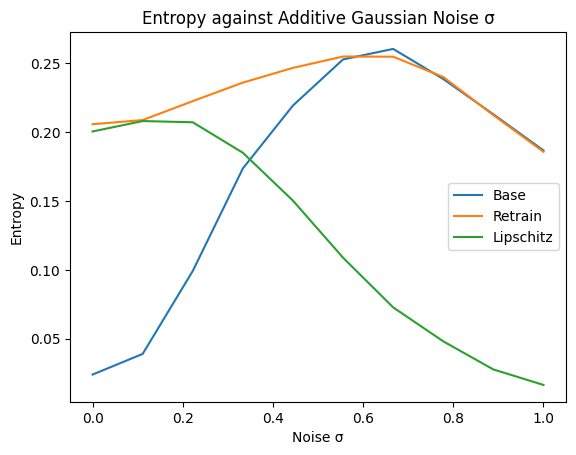

In [51]:
base_line = list(base_values.values())
retrain_line = list(retrain_values.values())
lipschitz_line = list(lipschitz_values.values())
print(base_line)
print(base_values.keys())

xs = [0] + [std_dev_upper_bound / n_perturbations * i for i in range(1, n_perturbations + 1)]
print(len(xs), len(base_line), len(retrain_line), len(lipschitz_line))
#plot error bars
# plt.errorbar(xs, base_line, yerr=list(base_var.values()), label="Base")
# plt.errorbar(xs, retrain_line, yerr=list(retrain_var.values()), label="Retrain")
# plt.errorbar(xs, lipschitz_line, yerr=list(lipschitz_var.values()), label="Lipschitz")

# #plot lines
plt.plot(xs, base_line, label="Base")
plt.plot(xs, retrain_line, label="Retrain")
plt.plot(xs, lipschitz_line, label="Lipschitz")

plt.title("Entropy against Additive Gaussian Noise σ")
plt.xlabel("Noise σ")
plt.ylabel("Entropy")
plt.legend()
plt.show()

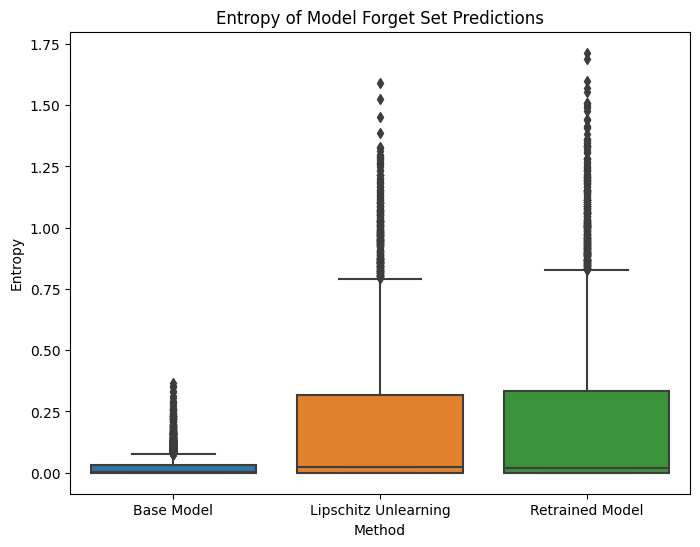

In [64]:
make_boxplot(
    [base_entropy_list, lip_entropy_list, retrain_entropy_list],
    title="Entropy of Model Forget Set Predictions",
    x_label="Method",
    y_label="Entropy",
    x_ticklabels=["Base Model", "Lipschitz Unlearning", "Retrained Model"],
    save_path="entropy.png",
    showfliers = False)

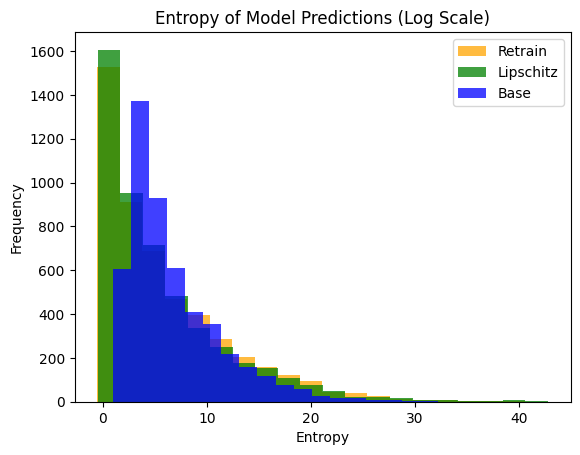

In [65]:
# plot histogram
plt.hist(-np.log(retrain_entropy_list), bins=20, label="Retrain", alpha=0.75, color='orange')
plt.hist(-np.log(lip_entropy_list), bins=20, label="Lipschitz", alpha=0.75, color='g')
plt.hist(-np.log(base_entropy_list), bins=20, label="Base", alpha=0.75, color='b')
plt.title("Entropy of Model Predictions (Log Scale)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [66]:
from scipy.stats import wilcoxon

print(f'Wilcoxon for Base model and Retrained model: p={wilcoxon(base_entropy_list, retrain_entropy_list)[1]}')
print(f'Wilcoxon for Base model and Lipschitz model: p={wilcoxon(base_entropy_list, lip_entropy_list)[1]}')
print(f'Wilcoxon for Lipschitz model and Retrained model: p={wilcoxon(lip_entropy_list, retrain_entropy_list)[1]}')

Wilcoxon for Base model and Retrained model: p=1.3115727630339086e-264
Wilcoxon for Base model and Lipschitz model: p=1.6481137897159184e-288
Wilcoxon for Lipschitz model and Retrained model: p=0.9085219870084502


In [67]:
base_model_retain_entropy, base_model_var, base_entropy_list = calculate_mean_entropy(model, retain_loader)
print(f"Base model forget entropy: {base_model_retain_entropy}")

retrain_model_retain_entropy, ret_var, retrain_entropy_list = calculate_mean_entropy(retrained_model, retain_loader)
print(f"Retrain model forget entropy: {retrain_model_retain_entropy}")

lip_entropy, lip_var, lip_entropy_list = calculate_mean_entropy(lipschitz_model, retain_loader)
print(f"Lipschitz model forget entropy: {lip_entropy}")


Base model forget entropy: 0.02266535240683401
Retrain model forget entropy: 0.019551020706744245
Lipschitz model forget entropy: 0.019551020706744245


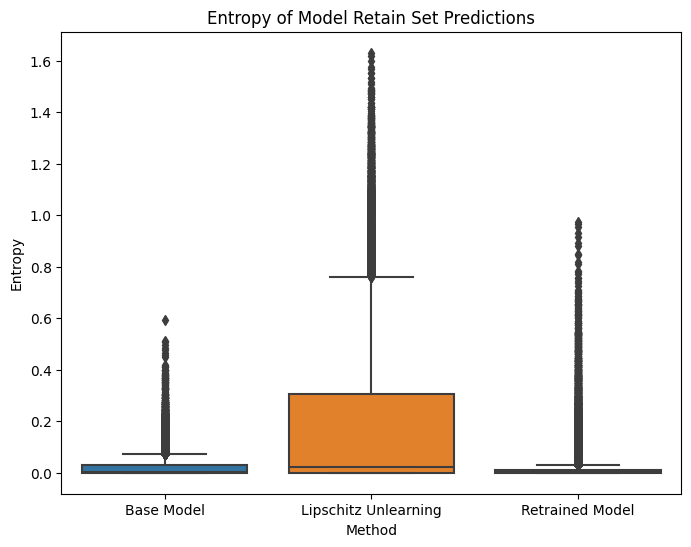

In [68]:
make_boxplot(
    [base_entropy_list, lip_entropy_list, retrain_entropy_list],
    title="Entropy of Model Retain Set Predictions",
    x_label="Method",
    y_label="Entropy",
    x_ticklabels=["Base Model", "Lipschitz Unlearning", "Retrained Model"],
    save_path="entropy.png",)

In [69]:
from scipy.stats import wilcoxon
print("Retain Set: \n")
print(f'Wilcoxon for Base model and Retrained model: p={wilcoxon(base_entropy_list, retrain_entropy_list)[1]}')
print(f'Wilcoxon for Base model and Lipschitz model: p={wilcoxon(base_entropy_list, lip_entropy_list)[1]}')
print(f'Wilcoxon for Lipschitz model and Retrained model: p={wilcoxon(lip_entropy_list, retrain_entropy_list)[1]}')

Retain Set: 

Wilcoxon for Base model and Retrained model: p=0.0
Wilcoxon for Base model and Lipschitz model: p=0.0
Wilcoxon for Lipschitz model and Retrained model: p=0.0
